c:\Users\Mohsin\AppData\Local\anaconda3\envs\mpyt\lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


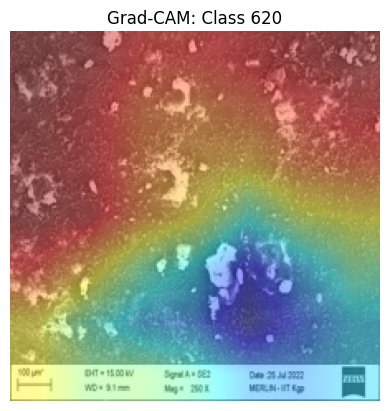

In [6]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the pretrained ResNet50 model
model = models.resnet50(pretrained=True)
model.eval()

# Load and preprocess the image
img_path =  r'E:\Healthcare_programming\dataset\an_30\7days\Img_Slide8_No0.png'
image = Image.open(img_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
input_tensor = transform(image).unsqueeze(0)

# Hooks to capture features and gradients
grads = []
features = []

def forward_hook(module, input, output):
    features.append(output)

def backward_hook(module, grad_in, grad_out):
    grads.append(grad_out[0])

# Hook the last convolutional layer
target_layer = model.layer4[-1]
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# Forward pass
output = model(input_tensor)
pred_class = output.argmax().item()
model.zero_grad()
output[0, pred_class].backward()

# Compute Grad-CAM
grad = grads[0]
feature = features[0]
weights = grad.mean(dim=[2, 3], keepdim=True)
cam = (weights * feature).sum(dim=1).squeeze()
cam = torch.relu(cam)
cam = cam - cam.min()
cam = cam / cam.max()
cam = cam.detach().numpy()

# Overlay the heatmap
heatmap = cv2.resize(cam, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
original = np.array(image.resize((224, 224)))
overlay = cv2.addWeighted(original, 0.6, heatmap, 0.4, 0)

# Display
plt.imshow(overlay)
plt.title(f"Grad-CAM: Class {pred_class}")
plt.axis('off')
plt.show()
